In [1]:
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
output_notebook()
import bokeh as bh
from sklearn.preprocessing import LabelEncoder
import gc
from glob import glob
import matplotlib.pyplot as plt
import re
from math import ceil
import xgboost as xgb
from sklearn.model_selection import GroupKFold,KFold,StratifiedKFold,train_test_split,TimeSeriesSplit
import random
import operator
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import datetime 
import lightgbm as lgb
import fastai.tabular as ft
pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
train_id = pd.read_csv('train_identity.csv')
train_trans = pd.read_csv('train_transaction.csv')
train_df = train_trans.merge(train_id,how='left',on=['TransactionID'])

In [3]:
test_id = pd.read_csv('test_identity.csv')
test_trans = pd.read_csv('test_transaction.csv')
test_df = test_trans.merge(test_id,how='left',on=['TransactionID'])

In [4]:
train_df = train_trans
test_df = test_trans


In [5]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'netzero.net': 'other',
          'optonline.net': 'other', 'comcast.net': 'other', 
          'cfl.rr.com': 'other', 'sc.rr.com': 'other',
          'suddenlink.net': 'other', 'windstream.net': 'other',
          'gmx.de': 'other', 'earthlink.net': 'other', 
          'servicios-ta.com': 'other', 'bellsouth.net': 'other', 
          'web.de': 'other', 'mail.com': 'other',
          'cableone.net': 'other', 'roadrunner.com': 'other', 
          'protonmail.com': 'other', 'anonymous.com': 'other',
          'juno.com': 'other', 'ptd.net': 'other',
          'netzero.com': 'other', 'cox.net': 'other', 
          'hotmail.co.uk': 'microsoft', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
          'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 
          'hotmail.com': 'microsoft',  
          'hotmail.fr': 'microsoft',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
           'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'embarqmail.com': 'centurylink', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
           'aol.com': 'aol', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')


In [6]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def define_indexes(df):
    
    # create date column
    START_DATE = '2017-11-30'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT_n'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
   # ft.da
    df['year'] = df['TransactionDT_n'].dt.year
    df['week'] = df['TransactionDT_n'].dt.week
    df['month'] = df['TransactionDT_n'].dt.month
    df['dow'] = df['TransactionDT_n'].dt.dayofweek
    df['hour'] = df['TransactionDT_n'].dt.hour
    df['day'] = df['TransactionDT_n'].dt.day
  
   
    # create card ID 
    cards_cols= ['card1', 'card2', 'card3', 'card5']
    for card in cards_cols: 
        if '1' in card: 
            df['card_id']= df[card].map(str)
        else : 
            df['card_id']+= ' '+df[card].map(str)
    
    # small correction of the Card_ID
    df['Card_ID']=df['card_id'].apply(corret_card_id)

    return df

In [7]:
train_df = define_indexes(train_df)
test_df = define_indexes(test_df)

### v1 - fet

In [8]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'netzero.net': 'other',
          'optonline.net': 'other', 'comcast.net': 'other', 
          'cfl.rr.com': 'other', 'sc.rr.com': 'other',
          'suddenlink.net': 'other', 'windstream.net': 'other',
          'gmx.de': 'other', 'earthlink.net': 'other', 
          'servicios-ta.com': 'other', 'bellsouth.net': 'other', 
          'web.de': 'other', 'mail.com': 'other',
          'cableone.net': 'other', 'roadrunner.com': 'other', 
          'protonmail.com': 'other', 'anonymous.com': 'other',
          'juno.com': 'other', 'ptd.net': 'other',
          'netzero.com': 'other', 'cox.net': 'other', 
          'hotmail.co.uk': 'microsoft', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
          'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 
          'hotmail.com': 'microsoft',  
          'hotmail.fr': 'microsoft',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
           'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'embarqmail.com': 'centurylink', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
           'aol.com': 'aol', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')


In [9]:
train_df['Trans_min_mean'] = train_df['TransactionAmt'] - train_df['TransactionAmt'].mean()
train_df['Trans_min_std'] = train_df['Trans_min_mean'] / train_df['TransactionAmt'].std()
test_df['Trans_min_mean'] = test_df['TransactionAmt'] - test_df['TransactionAmt'].mean()
test_df['Trans_min_std'] = test_df['Trans_min_mean'] / test_df['TransactionAmt'].std()

In [10]:
train_df['TransactionAmt_to_mean_card_id'] = train_df['TransactionAmt'] - train_df.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_card_id'] = train_df['TransactionAmt_to_mean_card_id'] / train_df.groupby(['Card_ID'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_mean_card_id'] = test_df['TransactionAmt'] - test_df.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_card_id'] = test_df['TransactionAmt_to_mean_card_id'] / test_df.groupby(['Card_ID'])['TransactionAmt'].transform('std')

In [11]:
train_df['first_value_card1'] = train_df['card1'].astype(str).str[0:1].astype(float)
train_df['two_value_card1'] = train_df['card1'].astype(str).str[0:2].astype(float)

test_df['first_value_card1'] = test_df['card1'].astype(str).str[0:1].astype(float)
test_df['two_value_card1'] = test_df['card1'].astype(str).str[0:2].astype(float)

train_df['card2'] = train_df['card2'].fillna(0)
train_df['first_value_card2'] = train_df['card2'].astype(str).str[0:1].astype(float)
train_df['two_value_card2'] = train_df['card2'].astype(str).str[0:2].astype(float)

test_df['card2'] = test_df['card2'].fillna(0)
test_df['first_value_card2'] = test_df['card2'].astype(str).str[0:1].astype(float)
test_df['two_value_card2'] = test_df['card2'].astype(str).str[0:2].astype(float)

### V2 - Fet

In [12]:
train_df['TransactionAmt_decimal'] = ((train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)) * 1000).astype(int)
test_df['TransactionAmt_decimal'] = ((test_df['TransactionAmt'] - test_df['TransactionAmt'].astype(int)) * 1000).astype(int)

# Count encoding for card1 feature. 
# Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
train_df['card1_count_full'] = train_df['card1'].map(pd.concat([train_df['card1'], test_df['card1']], ignore_index=True).value_counts(dropna=False))
test_df['card1_count_full'] = test_df['card1'].map(pd.concat([train_df['card1'], test_df['card1']], ignore_index=True).value_counts(dropna=False))


# Some arbitrary features interaction
# for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
#                 'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

#     f1, f2 = feature.split('__')
#     train_df[feature] = train_df[f1].astype(str) + '_' + train_df[f2].astype(str)
#     test_df[feature] = test_df[f1].astype(str) + '_' + test_df[f2].astype(str)

#     le = LabelEncoder()
#     le.fit(list(train_df[feature].astype(str).values) + list(test_df[feature].astype(str).values))
#     train_df[feature] = le.transform(list(train_df[feature].astype(str).values))
#     test_df[feature] = le.transform(list(test_df[feature].astype(str).values))
    
# for feature in ['id_34', 'id_36']:
#     if feature in cols:
#         # Count encoded for both train and test
#         train_df[feature + '_count_full'] = train_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))
#         test_df[feature + '_count_full'] = test_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))
        
# for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
#     if feature in cols:
#         # Count encoded separately for train and test
#         train_df[feature + '_count_dist'] = train_df[feature].map(train_df[feature].value_counts(dropna=False))
#         test_df[feature + '_count_dist'] = test_df[feature].map(test_df[feature].value_counts(dropna=False))


### V3 - Fets

In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2020-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
train_df['is_holiday'] = (train_df['TransactionDT_n'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
test_df['is_holiday'] = (test_df['TransactionDT_n'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [14]:
test_df['is_holiday'].value_counts()

0    489635
1     17056
Name: is_holiday, dtype: int64

In [15]:
cols = list(train_df.columns)
for i in ['isFraud','TransactionDT_n','TransactionDT']:
    cols.remove(i)

In [16]:
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df

In [17]:
i_cols = ['card1','card2','card3','card5'] 
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

### V4 Fets

In [18]:
i_cols = ['C'+str(i) for i in range(1,15)]

####### Global Self frequency encoding
# self_encoding=False because 
# I want to keep original values
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)


In [19]:
for df in [train_df, test_df]:
    df['bank_type'] = df['card3'].astype(str) +'_'+ df['card5'].astype(str)

In [1]:
cont_cols = ['card1','addr1']
cont_combs = ['card1','card2','card3','addr2']
agg_cols = ['TransactionAmt']

In [21]:
# cont_cols = ['card1','card2','hour','day','week','month']
# cont_combs = [['card1','card2','hour'],['card1','card2','day'],['card1','card2','week'],['card1','card2','month']]
# agg_cols = ['TransactionAmt','V258','V202']
# def cont_aggs(train_df, test_df, cont_cols,agg_cols):
#     temp_df = pd.concat([train_df[cont_cols + agg_cols], test_df[cont_cols + agg_cols]])
#     rm_cols = []
#     for j in cont_cols:
#         for col in agg_cols:
#             temp_agg = temp_df.groupby(j).agg({
#                                             col: [("mean_"+str(col)+"_"+j, "mean"),
#                                                ("sd_"+str(col)+"_"+j, lambda x: np.std(x))]      
#                                           })
            
            
#             temp_agg.columns = temp_agg.columns.droplevel()
#             temp_agg = temp_agg.reset_index(drop=False)
#             train_df = train_df.merge(temp_agg, on=j, how="left")
#             test_df = test_df.merge(temp_agg, on=j, how="left")
#             mn_delta = str(col)+"_"+j+"_delta_mean"
#             sd_delta = str(col)+"_"+j+"_delta_sd"
#             mn = "mean_"+str(col)+"_"+j
#             sd = "sd_"+str(col)+"_"+j
#             rm_cols.extend([mn,sd])
#             train_df[mn_delta] = train_df[mn] - train_df[str(col)]
#             train_df[sd_delta] = (train_df[mn] - train_df[str(col)])/train_df[sd]
#             test_df[mn_delta] = test_df[mn] - test_df[str(col)]
#             test_df[sd_delta] = (test_df[mn] - test_df[str(col)])/test_df[sd]
        
#     return train_df,test_df,rm_cols
# train_df,test_df,rm_cols = cont_aggs(train_df, test_df, cont_cols,agg_cols)

In [22]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [23]:
train_mv = missing_data(train_df)
test_mv = missing_data(test_df)

In [27]:
col_exp_lst = []
for i in cols:
    if (train_mv[i]['Percent'] > 70 and test_mv[i]['Percent'] > 70) or train_mv[i]['Percent'] > 80:
        col_exp_lst.append(i)

In [28]:
cols_for_model = list(train_df.columns)
col_exp_lst.extend(['isFraud','TransactionDT_n','TransactionDT','TransactionID','card_id'])
#col_exp_lst.extend(rm_cols)
for i in col_exp_lst:
    #print(i)
    cols_for_model.remove(i)

In [29]:
for f in cols_for_model:
    if train_df[f].dtype=='object':
        print(f+"-"+str(train_df[f].dtype))
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

ProductCD-object
card4-object
card6-object
P_emaildomain-object
M1-object
M2-object
M3-object
M4-object
M5-object
M6-object
M7-object
M8-object
M9-object
P_emaildomain_bin-object
P_emaildomain_suffix-object
R_emaildomain_suffix-object
Card_ID-object
bank_type-object


In [30]:
class MetricsMeter():    
    def __init__(self, y_true, y_pred, threshold):
        self.y_true = y_true        
        self.y_pred = y_pred        
        self.thresh = threshold            
    
    def fit(self):        
        metrics = {}        
        metrics['auc'] = roc_auc_score(self.y_true, self.y_pred)                
        self.y_pred = [1 if x > self.thresh else 0 for x in self.y_pred]        
        metrics['f1'] = f1_score(self.y_true, self.y_pred,average = 'macro')        
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()                
        metrics['sensitivity/recall'] = tp / (tp+fn)
        metrics['precision'] = tp / (tp+fp)
        metrics["accuracy"] = (tp + tn) / (tp + fp + fn + tn)
        metrics['specificity'] = tn / (tn+fp)
        return metrics

In [31]:
def RunLGB(x_build,x_val,y_build,y_val,x_test,seed, dep=8, data_leaf=511, hessian_leaf=50):
    dbuild = xgb.DMatrix(x_build,y_build)
    dval = xgb.DMatrix(x_val,y_val)
    watchlist = [(dbuild, 'train'), (dval, 'val')]
#     params = {}
    
    params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'nthreads':96,
                    'n_estimators':20000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': seed,
                    'early_stopping_rounds':100, 
                } 
    
#     params["objective"] = "binary"
#     params['metric'] = 'auc'
# #     params["max_depth"] = dep
#     params["num_leaves"] = 63
#     params["min_data_in_leaf"] = data_leaf
#     params["min_sum_hessian_in_leaf"] = hessian_leaf
#     params["learning_rate"] = 0.01
#     params["bagging_fraction"] = 0.913
#     params["feature_fraction"] = 0.2
#     params["feature_fraction_seed"] = seed
#     params["bagging_freq"] = 8
#     params["bagging_seed"] = seed
#     params["nthread"] = 96
#     params["lambda_l2"] = 0.95
#     params["lambda_l1"] = 0.95
#     params["verbosity"] = -1
#     
    num_rounds = 20000
    plst = list(params.items())
    lgbuild = lgb.Dataset(x_build, label=y_build)
    lgval = lgb.Dataset(x_val, label=y_val)
    model = lgb.train(params, lgbuild, num_rounds, valid_sets=[lgbuild,lgval], verbose_eval=200)
    pred_val = model.predict(x_val, num_iteration=model.best_iteration)
    pred_t = model.predict(x_test, num_iteration=model.best_iteration)

    return(model,pred_val,pred_t)

In [32]:
train = train_df.reset_index(drop =True)
x_train = train[cols_for_model]
y_train = train['isFraud']
dtest = xgb.DMatrix(test_df[cols_for_model].iloc[:])
td = test_df['TransactionID'].reset_index(drop=True)
x_test = test_df[cols_for_model]

In [33]:
n_splits = 6
folds = GroupKFold(n_splits=n_splits)
x_groups = x_train["month"].values
auc_list = []
pred_test_f = 0
pred_train = np.zeros(train.shape[0])
for fold_nm,(build_index, val_index) in enumerate(folds.split(x_train, x_train, groups=x_groups)):
    print('fold number:', fold_nm)
    x_build = x_train.iloc[build_index]
    y_build = y_train.iloc[build_index]
    x_val = x_train.iloc[val_index]
    y_val = y_train.iloc[val_index]
    
    pred_val = 0
    pred_test = 0
    n_models = 0.
    
    model,pred_v,pred_t = RunLGB(x_build,x_val,y_build,y_val,x_test,seed = 10999973) 
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
#     model,pred_v,pred_t = RunLGB(x_build,x_val,y_build,y_val,x_test,seed = 99)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1

    
#     model,pred_v,pred_t = RunLGB(x_build,x_val,y_build,y_val,x_test,seed = 90351) 
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    auc = roc_auc_score(y_val, pred_val)
    auc_list.append(auc)

    
    pred_train[val_index] = pred_val
    print(min(pred_train)),print(max(pred_train))
    pred_test_f += pred_test / n_splits
    print(min(pred_test_f)),print(max(pred_test_f))
    
    #xgb_preds_lst.append(clf_xgb.predict(dtest))  
    #models.append(clf_xgb)
print(np.mean(auc_list))

fold number: 0
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.957716	valid_1's auc: 0.889349
[400]	training's auc: 0.984735	valid_1's auc: 0.90159
[600]	training's auc: 0.993401	valid_1's auc: 0.905973
[800]	training's auc: 0.996894	valid_1's auc: 0.906933
[1000]	training's auc: 0.998461	valid_1's auc: 0.907612
Early stopping, best iteration is:
[1034]	training's auc: 0.998615	valid_1's auc: 0.907672
0.0
0.9953017888432166
2.2832985949487503e-05
0.16623954020991386
fold number: 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.956449	valid_1's auc: 0.914578
[400]	training's auc: 0.983749	valid_1's auc: 0.930767
[600]	training's auc: 0.993096	valid_1's auc: 0.935577
[800]	training's auc: 0.996884	valid_1's auc: 0.937262
[1000]	training's auc: 0.998459	valid_1's auc: 0.938257
[1200]	training's auc: 0.999268	valid_1's auc: 0.938431
[1400]	training's auc: 0.999635	valid_1's auc: 0.938573
Early stopping, best ite

In [34]:
print(roc_auc_score(y_train, pred_train)) #0.9344529730673139   #0.9363187584218378

0.9343996698519951


In [45]:
pred_df = pd.DataFrame(pred_test_f ,columns = ['isFraud'])

In [46]:
fnl = pd.concat([td, pred_df], axis=1)

In [47]:
predv1_data = pd.concat([train['TransactionID'],pd.DataFrame(pred_train ,columns = ['v1pred'])])

In [48]:
fnl.to_csv("lgb_v4_preds_x3.csv",index=False)


In [52]:
cont_cols = ['card1','card2','hour','day','week','month']
agg_cols = ['TransactionAmt','V258','V202']

In [57]:
def cont_aggs(train_df, test_df, cont_cols,agg_cols):
    temp_df = pd.concat([train_df[cont_cols + agg_cols], test_df[cont_cols + agg_cols]])
    for col in agg_cols:
        temp_agg = temp_df.groupby(cont_cols).agg({col:"sum",
                                       col:"mean",
                                       col:"min",
                                       col:"max",
                                       col:"std"        
                                      })
        train_df = train_df.merge(temp_agg, on=cont_cols, how="left")
        test_df = test_df.merge(temp_agg, on=cont_cols, how="left")
        
    return train_df, test_df

In [58]:
train_df, test_df = cont_aggs(train_df, test_df, cont_cols,agg_cols)

In [ ]:
predv1_data.to_csv("predv1_data_vx1_op1.csv",index=False)

In [35]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),cols_for_model)), columns=['Value','Feature'])

In [36]:
feature_imp_lst = feature_imp[feature_imp['Value'] >= 100]['Feature'].values

In [ ]:
feature_imp_lst.to_csv("lgb_v4_preds_x3.csv",index=False)

In [37]:
len(feature_imp_lst)

213

In [38]:
feature_imp.sort_values(by='Value')

,Value,Feature
0,0,V107
1,0,V28
2,0,V305
3,1,V117
4,1,V68
5,1,V89
6,2,V120
7,3,V119
8,3,V65
9,4,V27


ValueError: tree must be Booster, XGBModel or dict instance

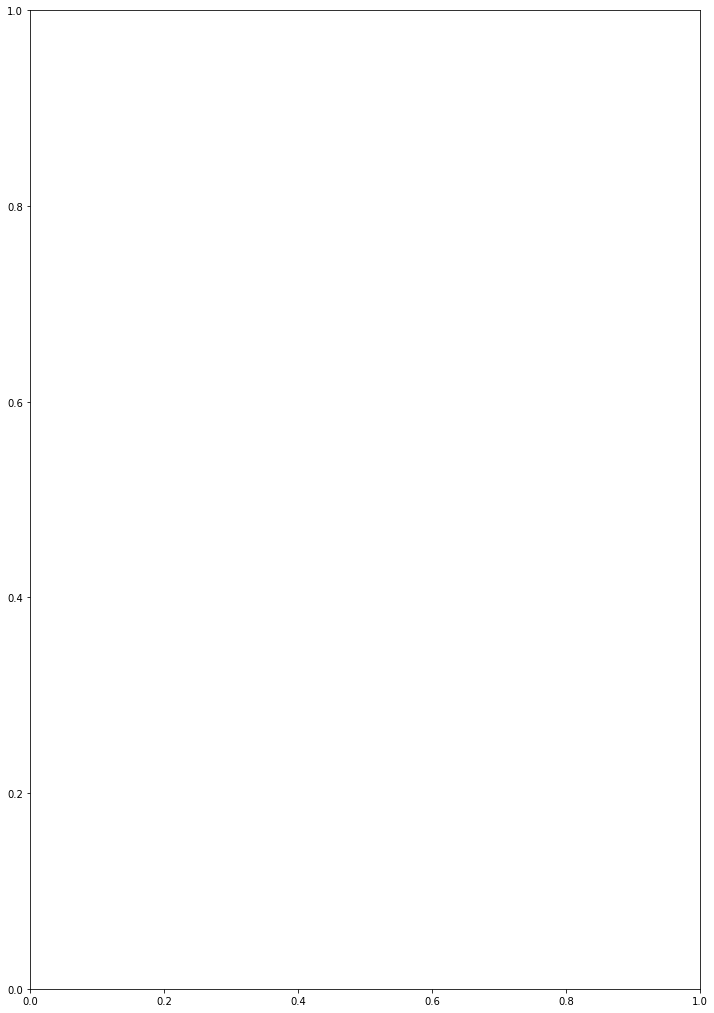

In [80]:
fig, ax = plt.subplots(figsize=(12,18))

xgb.plot_importance(model,importance_type= "gain", max_num_features=50, height=0.8, ax=ax)
plt.show()